# Local reliability: analyse

Evaluate local reliability for 3 uncertain parameters (fimp_14, psepbqarmax and triang). The intention is to try out the normalised severity function (relative to the solution severity); is the sample point more or less violated than the solution point?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from infeas import analyse
import easyvvuq as uq

In [2]:
campaign_names = [
    # "RMS_cons",
    # "no_eqs_RMS_cons",
    # "high_n_no_eqs_RMS_cons",
    # "more_rel",
    # "no_thresh",
    "sol_infeas_thresh",
    # "1p_sol_infeas_thresh",
]
# Campaign name bug: string pattern must match unique campaign
campaigns = {}
for campaign_name in campaign_names:
    campaigns[campaign_name] = {}
    campaigns[campaign_name]["campaign"], campaigns[campaign_name]["samples"] = (
        analyse.read_campaign(campaign_name=campaign_name)
    )

Reading in campaign database.
Campaign read in. Number of samples = 150


## Analysis

Check out the QOIs from the samples.

In [3]:
qois = [
    "rms_vio_constr_res",
]
campaigns[campaign_name]["samples"][qois].describe()

,rms_vio_constr_res
,0
count,150.000000
mean,0.010361
std,0.005925
min,-0.004141
25%,0.005589
50%,0.011199
75%,0.014996
max,0.021996


### Distribution of violated constraint residuals

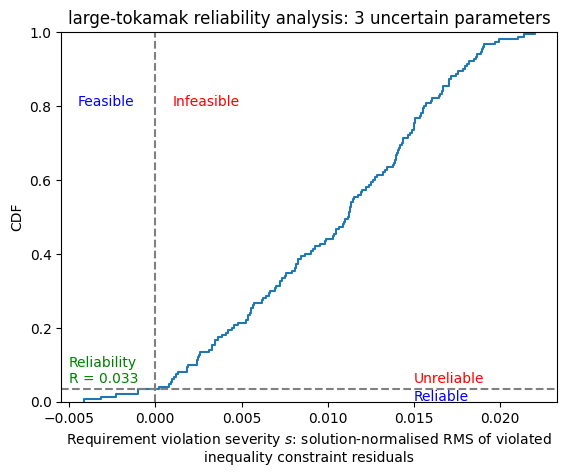

In [13]:
fig, ax = plt.subplots()

study_cdf_dfs = []
for campaign_name in campaigns:
    results = campaigns[campaign_name]["campaign"].analyse(
        qoi_cols=["rms_vio_constr_res"]
    )
    results.samples.columns = results.samples.columns.droplevel(1)
    samples = results.samples["rms_vio_constr_res"]
    samples = samples.rename(campaign_name)
    study_cdf_dfs.append(samples)

cdfs = pd.concat(study_cdf_dfs, axis=1)
sns.ecdfplot(data=cdfs, ax=ax)
ax.set_title("large-tokamak reliability analysis: 3 uncertain parameters")
ax.set_xlabel(
    "Requirement violation severity $s$: solution-normalised RMS of violated\ninequality constraint residuals"
)
ax.set_ylabel("CDF")

# Intersection line
x, y = ax.lines[0].get_data()
thresh = 0.0
# Find index of sign-change around threshold
thresh_idx = np.nonzero(np.diff(np.sign(x - thresh)))[0]
y_val = y[thresh_idx[0]]
ax.axhline(y_val, color="grey", linestyle="dashed")
ax.axvline(0.0, color="grey", linestyle="dashed")
ax.annotate("Infeasible", (0.001, 0.8), color="red")
ax.annotate("Feasible", (-0.0045, 0.8), color="blue")
ax.annotate("Unreliable", (0.015, 0.05), color="red")
ax.annotate("Reliable", (0.015, 0.003), color="blue")
ax.annotate(f"Reliability\nR = {y_val:.2}", (-0.005, 0.05), color="green")
ax.legend().remove()

This gives $R > 0$ for the solution point under uncertainty: 0.033 of the samples were more feasible than the solution point.

However, this normalisation of $s$ is unsatisfactory: it should be the case that $s_{soln} \leq 0$ (i.e. solver and severity metric agree that solution is feasible). This would remove the need for this normalisation.